The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


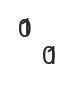

In [8]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.models import *
from src.datasets import NNAlignDataset, get_NNAlign_dataloader
from src.torch_utils import save_checkpoint, load_checkpoint
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
mpl.rcParams['figure.dpi'] = 180

In [36]:
from src.models import * 
std = StandardizerSequence()
nnmodel = NNAlignEF(50, 5, n_extrafeatures=5)
df = pd.read_csv('../data/aligned_icore/230418_cedar_aligned.csv')
print(df.columns)
nnmodel

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'HLA', 'agg_label',
       'fold', 'Peptide', 'wild_type', 'icore_mut', 'core_mut', 'len',
       'EL_rank_mut', 'EL_rank_wt', 'trueHLA_EL_rank', 'icore_mut_start',
       'len_icore_mut', 'icore_wt_aligned', 'icore_dissimilarity_score',
       'icore_len_mut', 'icore_len_wt', 'icore_anchor',
       'icore_mutation_position', 'icore_anchor_mutation', 'icore_mut_score',
       'icore_blsm_mut_score', 'aliphatic_index', 'boman', 'hydrophobicity',
       'isoelectric_point', 'VHSE1', 'VHSE3', 'VHSE7', 'VHSE8', 'seq_id',
       'core_wt_aligned', 'EL_rank_wt_aligned', 'ratio_rank',
       'foreignness_score', 'fullpep_vs_icore_rank', 'icore_improves_0_1',
       'mixed_input_0_1', 'mixed_rank_0_1', 'icore_improves_binder_0_1',
       'mixed_input_binder_0_1', 'mixed_rank_binder_0_1',
       'icore_improves_0_25', 'mixed_input_0_25', 'mixed_rank_0_25',
       'icore_improves_binder_0_25', 'mixed_input_binder_0_25',
       'mixed_rank_bind

NNAlignEF(
  (nnalign_model): NNAlign(
    (nnalign): NNAlignSinglePass(
      (in_layer): Linear(in_features=100, out_features=50, bias=True)
      (out_layer): Linear(in_features=50, out_features=1, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
      (act): SELU()
    )
    (standardizer): StandardizerSequence()
  )
  (ef_standardizer): StandardizerFeatures()
  (ef_inlayer): Linear(in_features=6, out_features=5, bias=True)
  (ef_outlayer): Linear(in_features=5, out_features=1, bias=True)
  (ef_act): SELU()
  (ef_dropout): Dropout(p=0.0, inplace=False)
)

In [37]:
loader, dataset = get_NNAlign_dataloader(df, max_len=12, window_size=5, encoding='BL50LO', feature_cols = ['isoelectric_point', 'VHSE1', 'VHSE3', 'VHSE7', 'VHSE8'], return_dataset=True)

torch.manual_seed(0)
nnmodel = NNAlignEF(50, 5, n_extrafeatures=5)
print('\nBefore fitting std\n')
print('nnalign', nnmodel.nnalign_model.nnalign.in_layer.weight[0][:3], nnmodel.nnalign_model.standardizer.mu[:3])
print('extraF', nnmodel.ef_standardizer.mu[:3], nnmodel.ef_inlayer.weight[0][:3])
x_tensor, x_mask, x_features = dataset.x_tensor[:100], dataset.x_mask[:100], dataset.x_features[:100]
nnmodel.fit_standardizer(x_tensor, x_mask, x_features)
print('\After fitting std/Saving\n')
print('nnalign', nnmodel.nnalign_model.nnalign.in_layer.weight[0][:3], nnmodel.nnalign_model.standardizer.mu[:3])
print('extraF', nnmodel.ef_standardizer.mu[:3], nnmodel.ef_inlayer.weight[0][:3])
save_checkpoint(nnmodel, './test_refactor_statedict.pt')

torch.manual_seed(13)
nnmodel = NNAlignEF(50, 5, n_extrafeatures=5)
print('\nNew model before load\n')
print('nnalign', nnmodel.nnalign_model.nnalign.in_layer.weight[0][:3], nnmodel.nnalign_model.standardizer.mu[:3])
print('extraF', nnmodel.ef_standardizer.mu[:3], nnmodel.ef_inlayer.weight[0][:3])
nnmodel = t


Before fitting std

nnalign tensor([-0.0398, -0.0830,  0.0809], grad_fn=<SliceBackward0>) tensor([0., 0., 0.])
extraF tensor([0., 0., 0.]) tensor([-0.0381, -0.3159, -0.2422], grad_fn=<SliceBackward0>)
\After fitting std/Saving

nnalign tensor([-0.0398, -0.0830,  0.0809], grad_fn=<SliceBackward0>) tensor([ 0.5296, -1.7889, -1.3327])
extraF tensor([ 6.6918,  0.1848, -0.2361]) tensor([-0.0381, -0.3159, -0.2422], grad_fn=<SliceBackward0>)
